In [452]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Mirror decent to compute the Stein importance weight
def mirror_descent_momentum(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    n = omega.shape[0]

    for j in range(iter):
        omega_m = alpha*omega_m + np.matmul(A,omega)
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*omega_m[i])
        omega = (1/omega.sum())*omega 
    #print(np.matmul(np.matmul(A,omega),omega),sum(i<0.1 for i in n*omega)/n)

    return omega 



class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        d = theta.shape[1]
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)# the bandwith for the reproducing kernal here is 2*h**2

        dxkxy = np.zeros([theta.shape[0],d])
        for i_index in range(theta.shape[0]):
            dxkxy[i_index] = np.matmul(Kxy[i_index], theta[i_index] - theta) /(h**2)

        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        theta_out = np.zeros([n_iter,theta.shape[0],theta.shape[1]])
   
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1)) 
            
            theta_out[iter] = theta
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = bandwidth)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            theta = theta + stepsize * grad_theta 
   
        return theta_out
    


class BETASVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        d = theta.shape[1]
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2) # the bandwith for the reproducing kernal here is 2*h**2

        dxkxy = np.zeros([theta.shape[0],d])
        for i_index in range(theta.shape[0]):
            dxkxy[i_index] = np.matmul(Kxy[i_index], theta[i_index] - theta) /(h**2)
        
        ddkxy=np.zeros([theta.shape[0],theta.shape[0]])
        ddkxy= np.multiply(Kxy,d/h**2-pairwise_dists/h**4)
        return (Kxy, dxkxy, ddkxy, 2*h**2)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        n = theta.shape[0]
        omega = 1/n*np.ones(n)
        theta_out = np.zeros([n_iter,n,theta.shape[1]])

        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1)) 

            lnpgrad = lnprob(theta)
            theta_out[iter]=theta
         
            # calculating the kernel matrix
            kxy, dxkxy,ddkxy, h = self.svgd_kernel(theta, h = bandwidth)  

            d_kernal_xj_xi = np.zeros([n,n])
            for i_index in range(n):
                d_kernal_xj_xi[i_index] = np.matmul(lnpgrad[i_index], (theta[i_index] - theta).transpose()) 
            d_kernal_xj_xi = np.multiply((d_kernal_xj_xi+d_kernal_xj_xi.transpose())* (2/h),kxy)

            SteinMatrix = (np.multiply(kxy,np.matmul(lnpgrad,lnpgrad.transpose()))\ 
            +ddkxy+d_kernal_xj_xi)/10**9                                               #rescale the Stein Matrix by a factor 10**9

            omega = mirror_descent_momentum(SteinMatrix,100,2,omega,0.2) 

            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]
            grad_theta = np.matmul(np.diag(np.maximum(n*omega,0.05)**(-0.5)),grad_theta)

            theta = theta + stepsize * grad_theta 

        return theta_out

In [453]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import numpy.matlib as nm


'''
    Example of Bayesian Logistic Regression (the same setting as Gershman et al. 2012):
    The observed data D = {X, y} consist of N binary class labels, 
    y_t \in {-1,+1}, and d covariates for each datapoint, X_t \in R^d.
    The hidden variables \theta = {w, \alpha} consist of d regression coefficients w_k \in R,
    and a precision parameter \alpha \in R_+. We assume the following model:
        p(\alpha) = Gamma(\alpha; a, b)
        p(w_k | a) = N(w_k; 0, \alpha^-1)
        p(y_t = 1| x_t, w) = 1 / (1+exp(-w^T x_t))
'''
class BayesianLR:
    def __init__(self, X, Y, batchsize=100, a0=1, b0=0.01):
        self.X, self.Y = X, Y
        # TODO. Y in \in{+1, -1}
        self.batchsize = min(batchsize, X.shape[0])
        self.a0, self.b0 = a0, b0
        
        self.N = X.shape[0]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0
    
        
    def dlnprob(self, theta):
        
        if self.batchsize > 0:
            batch = [ i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize) ]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])
            
        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]
        
        w = theta[:, :-1]  # logistic weights
        alpha = np.exp(theta[:, -1])  # the last column is logalpha
        d = w.shape[1]
        
        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))
        
        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))
        
        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d) , w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale
        
        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term
        
        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative 
    
    def evaluation(self, theta, X_test, y_test):
        theta = theta[:, :-1]
        M, n_test = theta.shape[0], len(y_test)

        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = np.divide(np.ones(n_test), (1 + np.exp(coff)))
        
        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        llh = np.mean(np.log(prob))
        return [acc, llh]

if __name__ == '__main__':
    data = scipy.io.loadmat('covertype.mat')
    
    X_input = data['covtype'][:, 1:]
    y_input = data['covtype'][:, 0]
    y_input[y_input == 2] = -1
    
    N = X_input.shape[0]
    X_input = np.hstack([X_input, np.ones([N, 1])])
    d = X_input.shape[1]
    D = d + 1
    
    # split the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)
    
    a0, b0 = 1, 0.01 #hyper-parameters
    model = BayesianLR(X_train, y_train, 100, a0, b0) # batchsize = 100
    
    # initialization
    M = 100  # number of particles
    theta0 = np.zeros([M, D])
    alpha0 = np.random.gamma(a0, b0, M); 
    for i in range(M):
        theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])]) # we set the mean of the normal distribution as -10

    
    n_iter = 20
    iteration = 100*np.arange(1,21) #iteraiton plotted in the picture
    step_size=20e-4



In [457]:
theta_out = SVGD().update(x0=theta0, lnprob=model.dlnprob, bandwidth=5, n_iter=2001, stepsize=step_size, alpha=0., debug=True)
#2*h**2=dimension=54, so bandwith=5 roughly
SVGD_ACC = np.zeros([n_iter,1,2])
for i in range(n_iter):
   SVGD_ACC[i] = model.evaluation(theta_out[i*100],X_test,y_test)

iter 1000
iter 2000


In [455]:
theta1_out = BETASVGD().update(x0=theta0, lnprob=model.dlnprob, bandwidth=5, n_iter=2001, stepsize=step_size, alpha=0., debug=True)
#2*h**2=dimension=54, so bandwith=5 roughly
BETASVGD_ACC = np.zeros([n_iter,1,2])
for i in range(n_iter):
   BETASVGD_ACC[i] = model.evaluation(theta1_out[i*100],X_test,y_test)


0.3765205582297084 0.0
0.30242042140389047 0.0
0.1737630136818024 0.2
0.1627991132881676 0.23
0.13506834359521808 0.28
0.16987600402948744 0.3
0.16697196444780982 0.23
0.22913959377607443 0.14
0.145541218293276 0.26
0.28891564644822965 0.17
0.1667362603707013 0.19
0.1597050821895111 0.36
0.1508151792108828 0.41
0.13350508586599164 0.47
0.13189525991591125 0.51
0.19582505619862905 0.18
0.12160114574985656 0.5
0.17987807101749947 0.47
0.1388030808645754 0.43
0.12357430945628525 0.48
0.15133784608676337 0.29
0.16392863783737427 0.36
0.13099115908267855 0.48
0.11854348618466413 0.44
0.144031360126723 0.35
0.1282532869798265 0.27
0.19582551960700842 0.22
0.12873430189738716 0.33
0.12028819756611875 0.44
0.21208766716137784 0.16
0.11132645151103512 0.19
0.16159748434869398 0.3
0.14225158732748733 0.35
0.1804452223665622 0.43
0.1478213039126851 0.47
0.12117813678497148 0.5
0.15889449009618312 0.48
0.1540159029228192 0.02
0.1243214409073081 0.17
0.1612445212407274 0.01
0.1001868349020207 0.37


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


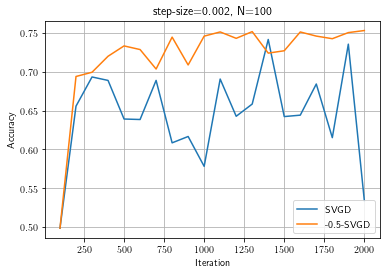

In [459]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.plot(iteration,SVGD_ACC[:,0,0],label='SVGD')
plt.plot(iteration,BETASVGD_ACC[:,0,0],label='-0.5-SVGD')

plt.legend(loc=4)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title(r'step-size='+str(step_size) +', N='+str(M))
plt.savefig('20SVGD100.eps')
plt.show()